In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model using automap_base()
Base = automap_base()
# reflect the tables with Base.prepare(), passing in the engine and reflect=True
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found with Base.classes
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
# Create our Session() and bind it to the engine
session = Session(engine)

# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data

In [8]:
inspector = inspect(engine)

# Get columns from each table
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column['name'])

print('---------------')

station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'])

id
station
date
prcp
tobs
---------------
id
station
name
latitude
longitude
elevation


In [9]:
# Calculate the date 1 year ago from the last data point in the database
# Find the last day in the data
last_measurement_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print("Last Day in Dataset: ", last_measurement_date[0])

Last Day in Dataset:  2017-08-23


In [10]:
# Use the datetime.timedelta() function to help calculating the difference of one year, 12 months, or 365 days
last_year_date = datetime.date(2017,8,23) - datetime.timedelta(days=365)
print("Date A Year Ago: ", last_year_date)

Date A Year Ago:  2016-08-23


In [11]:
# Use session.query() to retrieve the date and prcp columns, .filter() by the date you calculated above, and selecting .all() results
date_prcp_data = session.query(measurement.date, measurement.prcp).filter(measurement.date>=last_year_date).all()
date_prcp_data

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [12]:
# Save the query results as a Pandas DataFrame() and set the index to the date column
date_prcp_df = pd.DataFrame(date_prcp_data, columns=['date','precipitation']).set_index('date')
date_prcp_df

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


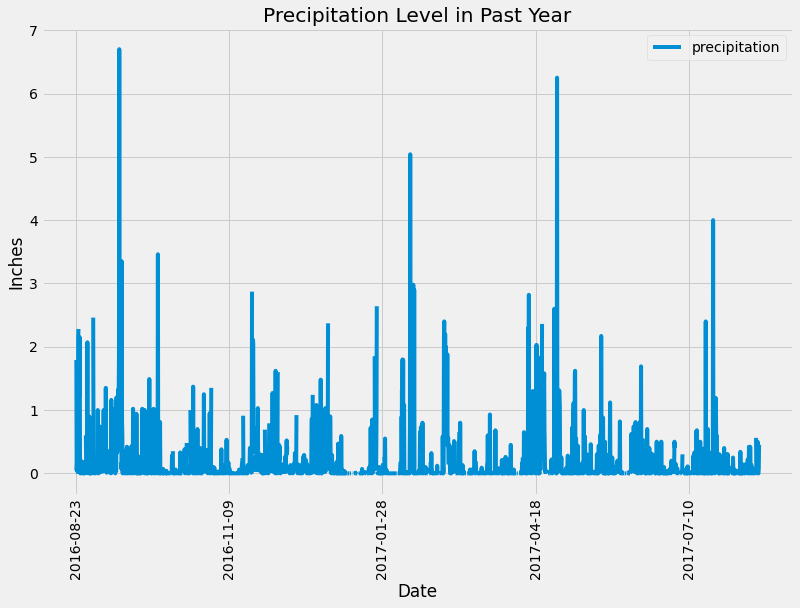

In [13]:
# Sort the dataframe by date
date_prcp_df = date_prcp_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data

date_prcp_df.plot(xlabel='Date',
                  ylabel='Inches',
                  title='Precipitation Level in Past Year',
                  figsize=(12,8),
                  rot=90)
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


##### Design a query to show how many stations are available in this dataset


In [15]:
# session.query(measurement.station).all()

In [16]:
session.query(measurement.station, measurement.tobs).filter(measurement.station == 'USC00519281').all()[0][1]

70.0

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order. Hint: session.query() the station column in the Measurement table
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
active_station_temp = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'Lowest temperature: {active_station_temp[0][0]}')
print(f'Highest temperature: {active_station_temp[0][1]}')
print(f'Average temperature: {round(active_station_temp[0][2],1)}')

Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.7


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_temp_data = session.query(measurement.date, measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date >= last_year_date).all()
active_temp_df = pd.DataFrame(active_temp_data)
active_temp_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


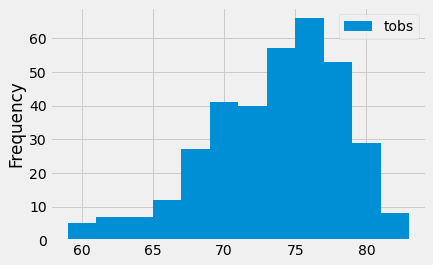

In [20]:
active_temp_df.plot(kind='hist', bins=12)
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return (session.query(func.min(measurement.tobs), 
                         func.avg(measurement.tobs), 
                         func.max(measurement.tobs))
                    .filter(measurement.date >= start_date)
                    .filter(measurement.date <= end_date)
                    .all())

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Assuming the trip was from 2017-06-01 to 2017-07-07
start_date = '2017-06-01'
end_date = '2017-07-07'
tmin, tavg, tmax = calc_temps(start_date, end_date)[0]
tmin, tavg, tmax 

(71.0, 77.38528138528139, 87.0)

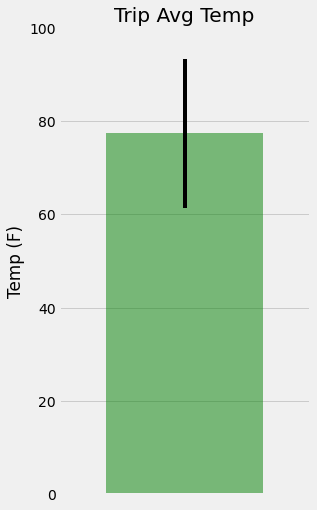

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(4,8))
ax = plt.bar(tavg,height=tavg,yerr=tmax-tmin,color='green',align='center', alpha=0.5, width=0.5)
plt.ylim(0,100)
plt.margins(0.3,0.3)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.xticks([])
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

(session.query(station.station, station.name, station.latitude, station.longitude, station.elevation)
       .filter(station.station == measurement.station)
       .filter(measurement.date>=start_date)
       .filter(measurement.date<=end_date)
       .group_by(measurement.station)
       .order_by(measurement.prcp.desc()).all())

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    return (session.query(func.min(measurement.tobs), 
                          func.avg(measurement.tobs), 
                          func.max(measurement.tobs))
                   .filter(func.strftime("%m-%d", measurement.date) == date)
                   .all())
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [58]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# end_date
end = datetime.datetime.strptime(end_date, '%Y-%m-%d')
start = datetime.datetime.strptime(start_date, '%Y-%m-%d')
date_delta = datetime.timedelta(days=1)

# Use the start and end date to create a range of dates
normals = []
while start <= end:
    normals.append(start)
    start =  start + date_delta

# Stip off the year and save a list of %m-%d strings
dates = [date.strftime("%m-%d") for date in normals]
dates

# Loop through the list of %m-%d strings and calculate the normals for each date
date_normals = []
for date in dates:
    date_normals.append(daily_normals(date)[0])
date_normals

[(64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864406779, 81.0),
 (67.0, 75.40350877192982, 81.0),
 (69.0, 75.41379310344827, 81.0),
 (68.0, 74.59322033898304, 81.0),
 (69.0, 74.60344827586206, 80.0),
 (70.0, 75.44067796610169, 82.0),
 (68.0, 73.96491228070175, 85.0),
 (68.0, 74.75862068965517, 82.0),
 (69.0, 75.15789473684211, 81.0),
 (68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0),
 (67.0, 74.21428571428571, 82.0),
 (66.0, 75.01785714285714, 81.0),
 (69.0, 74.88679245283019, 80.0),
 (67.0, 74.91525423728814, 80.0),
 (67.0, 75.59615384615384, 8

In [56]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_normals_df = pd.DataFrame(date_normals, columns=["tmin","tavg", "tmax"], index=dates )
date_normals_df

,tmin,tavg,tmax
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0
06-10,68.0,75.142857,81.0


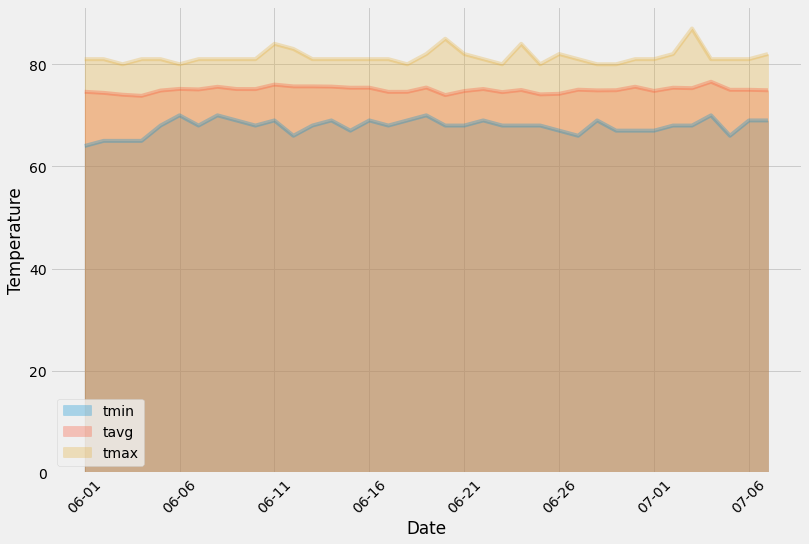

In [59]:
# Plot the daily normals as an area plot with `stacked=False`
date_normals_df.plot(kind='area',stacked=False, alpha=0.3, figsize=(12,8))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()